# Models and Evaluation

In [799]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

train_data = pd.read_csv('../assets/final/data.csv')
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(328, 10)
(354, 10)


In [800]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [801]:
def structure_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [802]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = structure_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (328, 8)

Test data shape:  (354, 8)

Train shape: (328, 1)

Test shape: (354, 1)


### Resampling

In [803]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [804]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)



Train data shape:  (564, 8)

Train shape: (564, 1)


### Algorithms

In [805]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, StratifiedKFold

k = 5
kr = 3
cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

In [806]:
import datetime    

# Trains a specific Model
def add_model(name, model, use_smote=False):
    x_fit_data = _smote_X_train.copy() if use_smote else _X_train.copy()
    y_fit_data = _smote_y_train if use_smote else _y_train

    X_test = _X_test.copy()

    start = datetime.datetime.now()
    
    model.fit(x_fit_data, np.ravel(y_fit_data.values))

    # Folding data and fitting. This overwrites previous results and by some magic gives better results :)
    # skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    # for train_index, test_index in skf.split(x_fit_data, y_fit_data):
    #     # print("TRAIN:", x_fit_data.iloc[train_index], "TEST:", y_fit_data.iloc[train_index].values)
    #    model.fit(x_fit_data.iloc[train_index], np.ravel(y_fit_data.iloc[train_index].values))
        
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_test': X_test, 
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [807]:
USE_SMOTE = False

In [808]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=USE_SMOTE
)

In [809]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=USE_SMOTE
)

In [810]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=USE_SMOTE
)

In [811]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=USE_SMOTE
)

In [812]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=USE_SMOTE
)

In [813]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=USE_SMOTE
)

## Prediction

# TODO:
- Stratified Cross-Validation. Turns out this would only make sense to test the model with the training data.
- Check we're SMOTE should be applied
- Test different models
- Clustering

In [814]:
def predict(name):
    result = results[name]
    pred = result['model'].predict(result['X_test'])
    result['test_pred'] = pred

for name in results.keys():
    # Predict paid column on test data
    predict(name)

In [815]:
def predict_proba(name):
    result = results[name]
    proba = result['model'].predict_proba(result['X_test'])
    result['test_pred_prob'] = proba

for name in results.keys():
    # Predict paid column on test data (Probability)
    predict_proba(name)

In [816]:
# Check result object
'''
test_pred -> Prediction of paid column on test data
trainpred -> Prediction of paid column on train data

test_pred_prob -> Prediction of Probability of paid column on test data
trainpred_prob -> Prediction of Probability of paid column on train data
'''
results

{'dtc': {'model': DecisionTreeClassifier(),
  'X_test':      amount  payments  is_co-owned  balance_min  balance_mean  mean_3m_influx  \
  0     93960      1566            0        800.0  54520.202247     2671.866667   
  1    260640      7240            0       -718.6  31518.182051   -10689.266667   
  2    232560      4845            0        200.0  40175.612500    -1580.300000   
  3    221880      3698            1       1000.0  44440.912676      217.033333   
  4     38520      3210            0        900.0  20231.313158    -3521.533333   
  ..      ...       ...          ...          ...           ...             ...   
  349  352704      7348            0        800.0  30797.487500      316.500000   
  350   52512      4376            0       1000.0  59684.298851   -17780.433333   
  351  139488      5812            0       1100.0  46755.305769     4344.633333   
  352   55632      2318            0        500.0  29645.320175     2018.966667   
  353  240900      4015          

### Check Prediction Results

In [817]:
import os

RES_PATH = '../assets/results'
if not os.path.exists(RES_PATH):
  os.mkdir(RES_PATH)

res = {'Id': ids_test.values, 'Predicted': results['rf']['test_pred_prob'][:,0]}    # Change 'rf' to a new variable to make it automatic

df = pd.DataFrame(data=res)
df.to_csv(RES_PATH + '/submission.csv', index=False)

df

,Id,Predicted
0,5895,0.05
1,7122,0.90
2,6173,0.03
3,6142,0.04
4,5358,0.35
...,...,...
349,4989,0.23
350,5221,0.15
351,6402,0.09
352,5346,0.12


In [818]:
print(results['rf']['test_pred_prob'])

[[0.05 0.95]
 [0.9  0.1 ]
 [0.03 0.97]
 [0.04 0.96]
 [0.35 0.65]
 [0.04 0.96]
 [0.   1.  ]
 [0.1  0.9 ]
 [0.09 0.91]
 [0.35 0.65]
 [0.04 0.96]
 [0.03 0.97]
 [0.08 0.92]
 [0.21 0.79]
 [0.07 0.93]
 [0.1  0.9 ]
 [0.25 0.75]
 [0.01 0.99]
 [0.13 0.87]
 [0.01 0.99]
 [0.12 0.88]
 [0.04 0.96]
 [0.84 0.16]
 [0.08 0.92]
 [0.43 0.57]
 [0.08 0.92]
 [0.12 0.88]
 [0.38 0.62]
 [0.06 0.94]
 [0.03 0.97]
 [0.1  0.9 ]
 [0.06 0.94]
 [0.06 0.94]
 [0.02 0.98]
 [0.   1.  ]
 [0.09 0.91]
 [0.27 0.73]
 [0.26 0.74]
 [0.15 0.85]
 [0.2  0.8 ]
 [0.03 0.97]
 [0.46 0.54]
 [0.03 0.97]
 [0.04 0.96]
 [0.15 0.85]
 [0.03 0.97]
 [0.11 0.89]
 [0.01 0.99]
 [0.25 0.75]
 [0.   1.  ]
 [0.77 0.23]
 [0.03 0.97]
 [0.05 0.95]
 [0.14 0.86]
 [0.1  0.9 ]
 [0.27 0.73]
 [0.03 0.97]
 [0.01 0.99]
 [0.05 0.95]
 [0.04 0.96]
 [0.15 0.85]
 [0.05 0.95]
 [0.08 0.92]
 [0.11 0.89]
 [0.02 0.98]
 [0.14 0.86]
 [0.04 0.96]
 [0.01 0.99]
 [0.24 0.76]
 [0.18 0.82]
 [0.08 0.92]
 [0.08 0.92]
 [0.07 0.93]
 [0.47 0.53]
 [0.86 0.14]
 [0.02 0.98]
 [0.19 0.81]

In [819]:
# function that opens RES_PATH + '/submission.csv' and round the Predict table in 1 decimal place
def submission():
  import pandas as pd
  df = pd.read_csv(RES_PATH + '/submission.csv')
  df.to_csv(RES_PATH + '/submission.csv', index=False)

submission()

## Evaluate Prediction with ROC Curve

Submission score: 0.8740740740740741% (~0.87%)


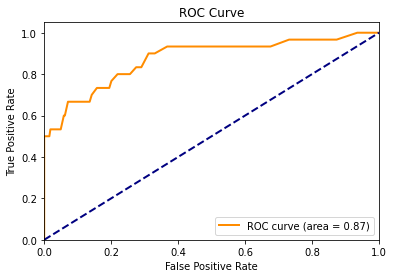

In [820]:
import pandas as pd

SHOW_GRAPH = True

SUBMISSION_PATH = "../assets/results/submission.csv"
RESULTS_PATH = "../assets/complete_clean/loan_dev.csv"

submission_pd = pd.read_csv(SUBMISSION_PATH)
results_pd = pd.read_csv(RESULTS_PATH)
mix_pd = pd.merge(submission_pd, results_pd, left_on='Id', right_on='loan_id', how='inner')

submission_scores = mix_pd["Predicted"].values.tolist()
results = mix_pd["paid"].values.tolist()

fpr, tpr, thresholds = roc_curve(results, submission_scores, pos_label=0)
auc = auc(fpr, tpr)

print(f"Submission score: {auc}% (~{round(auc, 2)}%)")

if SHOW_GRAPH:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


---------------------